In [18]:
___Author___='LumberJack Jyss'

In [19]:
print('LumberJack Trading AtidotCom TREND FORECAST\nLumberJack Jyss (c)')

LumberJack Trading AtidotCom TREND FORECAST
LumberJack Jyss (c)


In [20]:
print('Importation des librairies...')
import yahoofinancials
from yahoofinancials import YahooFinancials
import talib
import time
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import pandas_datareader as web
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
print('Librairies importées')

Importation des librairies...
Librairies importées


In [21]:
# PARAMETRES TEMPORELS INITIAUX
start = pd.to_datetime('2011-03-03')
end = pd.to_datetime('2019-04-10')
delta = round((end-start).days)
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')

Période d'étude :  2960
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  2368  jours 
Bloc 2 : 592  jours


In [22]:
# SCRAPING DES DONNES BRUTES
spy = web.DataReader('SPY','yahoo',start,end)

In [23]:
# NOMBRE DE NaN
spy.isnull().sum().sum(),spy.shape

(0, (2040, 6))

In [24]:
# DEFINITION DU DATAFRAME DES SIMANIM
simanim = pd.DataFrame(index=spy.index)

In [25]:
# DEFINITIONS DES SIMANIM

# ema8 = talib.EMA(spy['Close'], timeperiod=8) # => Coorelation
# simanim['ema8'] = ema8

# ema34 = talib.EMA(spy['Close'], timeperiod=34) # => Coorelation
# simanim['ema34'] = ema34

#atr8 = talib.EMA(spy['Close'], timeperiod=8) # => Coorelation
#simanim['atr8'] = atr8

rsi = talib.RSI(spy['Close'], timeperiod=21)
simanim['rsi'] = rsi

macd, macdsignal, macdhist = talib.MACD(spy['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
simanim['macd'] = macd
#simanim['macdsignal'] = macdsignal
#simanim['macdhist'] = macdhist

fastk, fastd = talib.STOCHRSI(spy['Close'], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
simanim['fastk'] = fastk
#simanim['fastd'] = fastd

# ad = talib.AD(spy['High'], spy['Low'], spy['Close'], spy['Volume']) # => Coorelation
# simanim['ad'] = ad

atr14 = talib.ATR(spy['High'], spy['Low'], spy['Close'], timeperiod=14)
simanim['atr14'] = atr14

wclprice = talib.WCLPRICE(spy['High'], spy['Low'], spy['Close'])
simanim['wclprice'] = wclprice

sine, leadsine = talib.HT_SINE(spy['Close'])
simanim['sine'] = sine
simanim['leadsine'] = leadsine

instant_trendline = talib.HT_TRENDLINE(spy['Close'])
simanim['instant_trendline'] = instant_trendline

#midprice5 = talib.MIDPRICE(spy['High'],spy['Low'], timeperiod=5) # Correlation 
#simanim['midprice5'] = midprice5

ultosc = talib.ULTOSC(spy['High'], spy['Low'], spy['Close'], timeperiod1=5, timeperiod2=9, timeperiod3=13)
simanim['ultosc'] = ultosc

obv = talib.OBV(spy['Close'], spy['Volume'])
simanim['obv'] = obv

ht_trendmode = talib.HT_TRENDMODE(spy['Close'])
simanim['ht_trendmode'] = ht_trendmode

In [26]:
# TREND GLISSANT 5 JOURS COEF +atr14*2
trend5 = []
hausse = []
baisse = []
stagne = []

In [27]:
for i in range(0,len(simanim)-4):
    
    ii = 0.01
    jour = spy.iloc[i,3]
    jour2 = spy.iloc[i+1,3]
    jour3 = spy.iloc[i+2,3]
    jour4 = spy.iloc[i+3,3]
    jour5 = spy.iloc[i+4,3]
    moy = (jour2+jour3+jour4+jour5)/4
    jtest = jour+(jour*ii)
    
    if jtest>moy:
        hausse.append(1)
        baisse.append(0)
        stagne.append(0)
    
    elif jtest<moy:
        hausse.append(0)
        baisse.append(1)
        stagne.append(0)


nb_row= len(hausse)

simanim.loc[:nb_row,'hausse'] = hausse

#simanim.loc[:nb_row,'baisse'] = baisse

simanim.shape

(2040, 12)

In [28]:
simanim = simanim.dropna()
simanim.isnull().sum().sum(),simanim.shape

(0, (1973, 12))

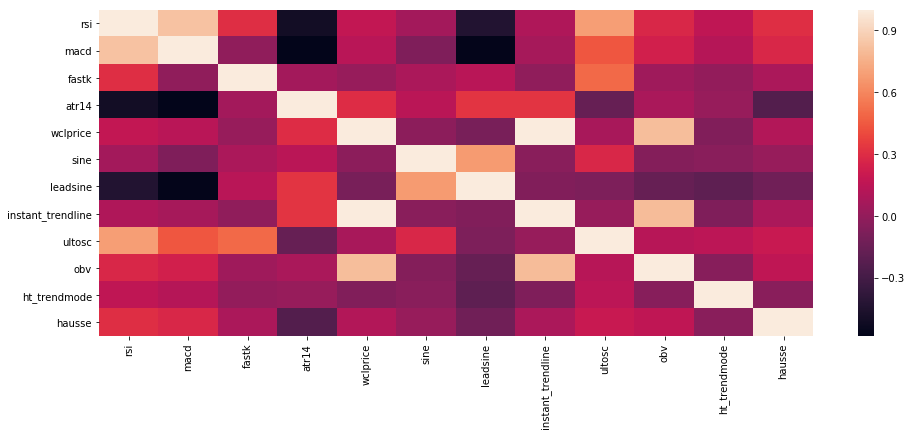

In [29]:
plt.figure(figsize=(16,6))
sns.heatmap(simanim.corr())
plt.show()

In [30]:
# SPLIT TRAIN ET TEST
X = simanim.iloc[:,:-1]
y = simanim.iloc[:,-2]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [31]:
X_train.shape

(1479, 11)

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit(maxiter = 500)
print(result.summary2())

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [32]:
classifier = LogisticRegression(
    penalty='l2',
    dual=False,
    tol=0.001,
    C=0.5,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=770,
    solver='newton-cg',
    max_iter=1000,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=-1,
)
classifier.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='auto',
          n_jobs=-1, penalty='l2', random_state=770, solver='newton-cg',
          tol=0.001, verbose=0, warm_start=False)

In [33]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[  4 157]
 [ 15 318]]


In [34]:
print('Accuracy de la regression logistique sue le test set: {:.2f}%'.format(classifier.score(X_test, y_test)*100))

Accuracy de la regression logistique sue le test set: 65.18%


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.02      0.04       161
           1       0.67      0.95      0.79       333

   micro avg       0.65      0.65      0.65       494
   macro avg       0.44      0.49      0.42       494
weighted avg       0.52      0.65      0.55       494



In [36]:
# BACKTEST

print('                       ==========================> BACKTEST <==========================')

                       ==========================> BACKTEST <==========================


In [37]:
import backtrader as bt
from datetime import datetime

In [38]:
start

Timestamp('2011-03-03 00:00:00')

In [39]:
end

Timestamp('2019-04-10 00:00:00')

In [40]:
backtest = pd.concat((y_train,y_test))

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10000.00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>]]

<Figure size 1152x432 with 0 Axes>

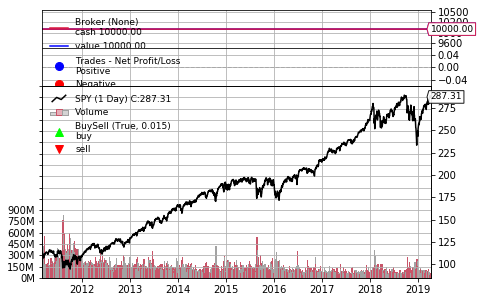

In [42]:
cerebro = bt.Cerebro()
data = bt.feeds.YahooFinanceData(dataname='SPY', fromdate=datetime(2011, 3, 3),
                                     todate=datetime(2019, 4, 10))

cerebro.broker.setcash(100000.0)
cerebro.adddata(data)
cerebro.broker.setcommission(commission=0.001)

#cerebro.run()
#plt.figure(figsize=(16,6))
#cerebro.plot()

from datetime import datetime
import backtrader as bt

class SmaCross(bt.SignalStrategy):
    params = (('pfast', 10), ('pslow', 30),)
    def __init__(self):
        sma1, sma2 = bt.ind.SMA(period=self.p.pfast), bt.ind.SMA(period=self.p.pslow)
        self.signal_add(bt.SIGNAL_LONG, bt.ind.CrossOver(sma1, sma2))

cerebro = bt.Cerebro()

data = bt.feeds.YahooFinanceData(dataname='MSFT', fromdate=datetime(2011, 1, 1),todate=datetime(2012, 12, 31))
cerebro.adddata(data)

cerebro.addstrategy(SmaCross)
cerebro.run()
plt.figure(figsize=(16,6))
cerebro.plot()